In [106]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch.optim as optim
from torch.autograd import Variable
from typing import Dict, Any, Tuple, Union, NamedTuple
import hydra
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lr = 1e-3
max_steps = 5000
print_freq = 100


torch.manual_seed(613) 

In [107]:
# Characteristic scales
lc = 1e-6  # Length scale [m]
cc = 1000  # Concentration scale [mol/m³]

# Physical constants
F = 96485.0  # Faraday constant [C/mol]
R = 8.3145  # Gas constant [J/(mol·K)]
T = 293.0  # Temperature [K]
k_B = 1.3806e-23  # Boltzmann constant [J/K]
eps0 = 8.85e-12  # Vacuum permittivity [F/m]
electron_charge = 1.6e-19  # Elementary charge [C]
E_max = 1.6 #V,
E_min = 1.2 #V

# Diffusion coefficients [m²/s]
D_OH = 5.3e-9  # OH⁻ diffusion coefficient (m²/s)
D_K = 1.96e-9       # K⁺ diffusivity (m²/s)

time_scale = 3000

# Time and potential scales
tc = lc**2 / D_OH   # Time scale based on OH⁻ diffusion (s)
phic = R*T/F  # Potential scale [V]

# Non-dimensionalized AEM-C parameters
# Reference scales for non-dimensionalization
rate_0 = 1e-6  # Reference rate [mol/cm²·s]
C_0 = 1.0      # Reference concentration [M] (1 M KOH)
E_0 = R * T / F  # Thermal voltage ≈ 0.026 V at 300K
theta_0 = 1.0  # Reference coverage (already dimensionless)

# Non-dimensional rate constant and parameters
k_star = 1.0           # Non-dimensional rate constant
zeta_star = 20.0       # Non-dimensional Frumkin interaction parameter
kappa_star = 32.0      # Non-dimensional activation parameter
m = 1.0                # Reaction order with respect to active species

# Species charges
z_K = 1.0
z_OH = -1.0

# Dielectric properties
epsilon_r = 78.5                         # Relative permittivity of water
epsilon_0 = 8.854e-12                    # Vacuum permittivity (F/m)
epsilon_f = epsilon_r * epsilon_0        # Electrolyte permittivity

# Bulk concentrations [mol/m³]
c_OH_bulk = 1000.0  # 1 M KOH
c_K_bulk = 1000.0  # 1 M KOH

# Dimensionless concentrations
c_OH_dimensionless = c_OH_bulk/cc
c_K_dimensionless = c_K_bulk/cc

# Reaction kinetics
k0 = 1e-6  # Exchange current density [A/m²]
gamma = 1.0  # Reaction order in OH⁻ [dimensionless]
phi_eq = 1.23  # Equilibrium potential [V vs RHE]
n = 4.0  # Electrons per O₂ molecule
A_sites = 1e-9

# Electrochemical parameters (non-dimensional)
E_eq_hat = 1.23 / phic      # Equilibrium potential (non-dimensional)
E_onset_hat = 1.48 / phic   # Onset potential (non-dimensional)
alpha = 0.5                 # Symmetry factor

# Geometry
L_domain = 1e-2  # Domain length [m]

# Dimensionless transport coefficients
D_OH_hat = D_OH * tc / (lc**2)              # Reference diffusivity (D_OH * tc / lc²)
D_K_hat = D_K *  tc / (lc**2)               # Relative to OH⁻ diffusivity
beta_hat = F * phic / (R*T)
lambda_d_sq = 0.1 #(epsilon_r * epsilon_0 * R * T * lc**2) / (F**2 * cc * phic**2)

In [108]:
#Define networks

class Swish(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self,x):
        return torch.sigmoid(x)*x
    

class FFN(nn.Module):
    """
    Fully Connected Feed Forward Neural Network.
    Args:
        input_dim: Number of input features
        output_dim: Number of output features  
        hidden_layers: Number of hidden layers
        layer_size: Size of each hidden layer
        activation: Activation function name ('swish', 'swoosh', 'swash', 'squash_swish', 'relu', 'tanh')
        initialize_weights: Whether to apply Xavier initialization
    """
    def __init__(
        self,
        input_dim: int = 3,
        output_dim: int = 1,
        hidden_layers: int = 5,
        layer_size: int = 20,
        activation: str = "swish",
        initialize_weights: bool = False
    ):
        super(FFN, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_layers = hidden_layers
        self.layer_size = layer_size
        self.activation = Swish()
        
        # Input layer
        self.input_layer = nn.Linear(input_dim, self.layer_size)
        
        # Hidden layers
        self.hidden_layers = nn.ModuleList([
            nn.Linear(self.layer_size, self.layer_size)
            for _ in range(self.num_layers)  
        ])
        
        # Output layer
        self.output_layer = nn.Linear(self.layer_size, output_dim)
        
        # Initialize weights
        if initialize_weights:
            self.initialize_weights()
    
    def initialize_weights(self):
        """Apply Xavier initialization to all linear layers"""
        # Initialize input layer
        nn.init.xavier_normal_(self.input_layer.weight)
        nn.init.zeros_(self.input_layer.bias)
        
        # Initialize hidden layers
        for layer in self.hidden_layers:
            nn.init.xavier_normal_(layer.weight)
            nn.init.zeros_(layer.bias)
        
        # Initialize output layer
        nn.init.xavier_normal_(self.output_layer.weight)
        nn.init.zeros_(self.output_layer.bias)
    
    def forward(self, x):
        x = self.activation(self.input_layer(x))
        
        for layer in self.hidden_layers: 
            x = self.activation(layer(x))
        
        return self.output_layer(x)


class ResidualBlock(nn.Module):
    """Single residual block: x + F(x)"""
    def __init__(self, layer_size, activation):
        super(ResidualBlock, self).__init__()
        self.layer_size = layer_size
        self.activation = activation
        
        # Two layers in each residual block
        self.linear1 = nn.Linear(layer_size, layer_size)
        self.linear2 = nn.Linear(layer_size, layer_size)
        
    def initialize_weights(self):
        nn.init.xavier_normal_(self.linear1.weight)
        nn.init.zeros_(self.linear1.bias)
        nn.init.xavier_normal_(self.linear2.weight)
        nn.init.zeros_(self.linear2.bias)
    
    def forward(self, x):
        identity = x  # Save input for residual connection
        
        # F(x) computation
        out = self.activation(self.linear1(x))
        out = self.linear2(out)  # No activation on final layer of block
        
        # Residual connection: x + F(x)
        out = out + identity
        
        # Activation after residual connection
        out = self.activation(out)
        
        return out
    
class ResidualFFN(nn.Module):
    def __init__(self, input_dim=3, output_dim=1, num_layers=8, layer_size=50, initialize_weights=True):
        super(ResidualFFN, self).__init__()
        self.layer_size = layer_size
        self.num_layers = num_layers
        self.activation = Swish()
        
        # Input projection to get to residual dimension
        self.input_layer = nn.Linear(input_dim, self.layer_size)
        
        # Residual blocks
        self.residual_layers = nn.ModuleList([
            ResidualBlock(self.layer_size, self.activation)
            for _ in range(self.num_layers)  
        ])
        
        # Output layer
        self.output_layer = nn.Linear(self.layer_size, output_dim)
        
        if initialize_weights:
            self.initialize_weights()
    
    def initialize_weights(self):
        """Apply Xavier initialization to all linear layers"""
        nn.init.xavier_normal_(self.input_layer.weight)
        nn.init.zeros_(self.input_layer.bias)
        
        for block in self.residual_layers:
            block.initialize_weights()
        
        nn.init.xavier_normal_(self.output_layer.weight)
        nn.init.zeros_(self.output_layer.bias)
    
    def forward(self, x):
        # Input projection
        x = self.activation(self.input_layer(x))
        
        # Residual blocks
        for residual_layer in self.residual_layers:
            x = residual_layer(x)
        
        # Output
        return self.output_layer(x)
    
"""
k_net = ResidualFFN(input_dim=3, output_dim=1, num_layers=3, layer_size=20) #ResNet Size as close to old FFN as possible. There is one extra layer here by nature of design.
oh_net = ResidualFFN(input_dim=3, output_dim=1, num_layers=3, layer_size=20
u_net = ResidualFFN(input_dim=3, output_dim=1, num_layers=3, layer_size=20)
"""
k_net = FFN() #ResNet Size as close to old FFN as possible. There is one extra layer here by nature of design.
oh_net =FFN()
u_net = FFN()
k_net.to(device)
oh_net.to(device)
u_net.to(device)

total_model_parameters = list(k_net.parameters()) + list(oh_net.parameters()) + list(u_net.parameters())

In [109]:
#gradient and sampling utils

class GradientResults(NamedTuple):
    """
    Container for gradient computation results.

    Organizes all computed derivatives in a structured way for easy access.
    """
    # Network predictions
    phi: torch.Tensor  # Potential φ
    c_k: torch.Tensor  # Cation vacancy concentration
    c_oh: torch.Tensor  # Anion vacancy concentration

    # Time derivatives
    c_k_t: torch.Tensor  # ∂c_cv/∂t
    c_oh_t: torch.Tensor  # ∂c_av/∂t

    # First spatial derivatives
    phi_x: torch.Tensor  # ∂φ/∂x
    c_k_x: torch.Tensor  # ∂c_cv/∂x
    c_oh_x: torch.Tensor  # ∂c_av/∂x

    # Second spatial derivatives
    phi_xx: torch.Tensor  # ∂²φ/∂x²
    c_k_xx: torch.Tensor  # ∂²c_cv/∂x²
    c_oh_xx: torch.Tensor  # ∂²c_av/∂x²


def _grad(x,dx):
    """Take the derrivative of x w.r.t dx"""

    return torch.autograd.grad(x,dx,torch.ones_like(dx),create_graph=True,retain_graph=True)[0]

def compute_gradients(x, t, E, clip_gradients=True, max_grad=1e3):
    """
    Compute gradients with built-in clipping and numerical stability.
    
    Args:
        x, t, E: Input tensors
        clip_gradients: Whether to clip computed gradients
        max_grad: Maximum allowed gradient magnitude
    """
    inputs_3d = torch.cat([x, t, E], dim=1)
    
    # Get network predictions
    phi = torch.clamp(u_net(inputs_3d), min=-5.0, max=5.0)  # Add bounds
    c_k_raw = k_net(inputs_3d)
    c_oh_raw = oh_net(inputs_3d)
    
    # Apply physical bounds
    c_k = torch.clamp(c_k_raw, min=1e-6, max=5.0)
    c_oh = torch.clamp(c_oh_raw, min=1e-6, max=5.0)
    
    # Helper function with clipping
    def clipped_grad(output, input_var, max_val=50.0):
        result = _grad(output, input_var)
        return torch.clamp(result, min=-max_val, max=max_val)
    
    # Direct derivatives with clipping
    c_k_t = clipped_grad(c_k, t)
    c_oh_t = clipped_grad(c_oh, t)
    
    # Compute first spatial derivatives
    phi_x = clipped_grad(phi, x)
    c_k_x = clipped_grad(c_k, x)
    c_oh_x = clipped_grad(c_oh, x)
    
    # Compute second spatial derivatives (more conservative clipping)
    phi_xx = clipped_grad(phi_x, x, max_val=25.0)
    c_k_xx = clipped_grad(c_k_x, x, max_val=25.0)
    c_oh_xx = clipped_grad(c_oh_x, x, max_val=25.0)
    
    return GradientResults(
        phi=phi, c_k=c_k, c_oh=c_oh,
        c_k_t=c_k_t, c_oh_t=c_oh_t,
        phi_x=phi_x, c_k_x=c_k_x, c_oh_x=c_oh_x,
        phi_xx=phi_xx, c_k_xx=c_k_xx, c_oh_xx=c_oh_xx,
    )


def sample_interior_points(
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Sample interior collocation points for PDE residuals.

        Args:
            networks: NetworkManager instance

        Returns:
            Tuple of (x, t, E) tensors with requires_grad=True for x and t
        """
        batch_size = 2048

        # Sample time and applied potential
        t = torch.rand(batch_size, 1, device=device, requires_grad=True) * time_scale / tc
        single_E = (
                torch.rand(1, 1, device=device)
                * (E_max - E_min)
                + E_min
            )
        E = single_E.expand(batch_size, 1)

        # Sample spatial coordinates within [0, L(t,E)]
        x = torch.rand(batch_size, 1, device=device, requires_grad=True) * L_domain/lc

        return x, t, E

def sample_boundary_points(
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Sample boundary collocation points for boundary conditions.

    Args:
        networks: NetworkManager instance

    Returns:
        Tuple of (x, t, E) tensors for boundary points
    """
    batch_size = 2 * 1024
    half_batch = batch_size // 2
    
    # IMPROVED: Better time sampling distribution
    # Mix uniform sampling with early-time bias (where dynamics are fast)
    t_uniform = torch.rand(batch_size//2, 1, device=device, requires_grad=True)
    t_early = torch.rand(batch_size//2, 1, device=device, requires_grad=True)  # Strong bias toward t=0
    
    t = torch.cat([t_uniform, t_early], dim=0) * time_scale / tc
    
    # Sample applied potentials (not single value per batch)
    E = torch.rand(batch_size, 1, device=device) * (E_max - E_min) + E_min
    
    # Sample spatial coordinates with bias toward electrode (where gradients are steep)
    x_uniform = torch.rand(half_batch, 1, device=device, requires_grad=True)
    x_near_electrode = torch.rand(half_batch, 1, device=device, requires_grad=True)**2  # Bias toward x=0
    
    x = torch.cat([x_uniform, x_near_electrode], dim=0) * L_domain / lc
    
    # Shuffle to mix different sampling strategies
    # indices = torch.randperm(batch_size)
    # x, t, E = x[indices], t[indices], E[indices]
    
    return x, t, E

def sample_initial_points(
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Sample initial condition points at t = 0.

    Args:
        networks: NetworkManager instance

    Returns:
        Tuple of (x, t, E) tensors for initial condition points
    """
    batch_size = 1024

    # Initial time (t = 0)
    t = torch.zeros(batch_size, 1, device=device, requires_grad=True) * time_scale / tc
    single_E = (
            torch.rand(1, 1, device=device)
            * (E_max - E_min)
            + E_min
        )
    E = single_E.expand(batch_size, 1)

    # Sample spatial coordinates
    x = (
        torch.rand(batch_size, 1, device=device, requires_grad=True) * L_domain/lc
    )

    return x, t, E

In [110]:
#Compute and generate all the relevant losses

def compute_rate_constants(t: torch.Tensor, E: torch.Tensor, single: bool = False):
        """
        Compute electrochemical rate constants using Butler-Volmer kinetics for the AEM-E mechanism.

        **Butler-Volmer Rate Expressions:**

        Frumkin behaviour is characteristic of chemical-potential driven mechanisms
        
        No Frumkin behaviour:

        rate = k theta [OH-]^m exp(-(alpha n F eta)/RT)

        With Frumkin behaviour:

        rate = k theta_a ^m [OH-] exp(-(zeta theta_a + kappa)/ RT)

        F = Faraday's constant                          C/mol
        R = Gas constant                                J/mol K
        T = Temperature                                 K
        k = rate constant                               varies
        alpha = activity                                
        [OH-]^m = concentration                         
        theta = surface coverage of active species      dimensionless
        kappa = activation energy parameter             J/mol
        zeta = Frumkin interaction parameter            depends
        
        Args:
            t: Time tensor (dimensionless)
            E: Applied potential tensor
            networks: NetworkManager instance
            single: Whether computing for single point or batch

        Returns:
            Rate constant
        """
        if single:
            batch_size = 1
            x_surf = torch.zeros(1, 1, device=device)
        else:
            batch_size = t.shape[0]
            x_surf = torch.zeros(batch_size, 1, device=device)

        # Get surface potential (already non-dimensional from u_net)
        inputs_surf = torch.cat([x_surf, t, E], dim=1)
        phi_star = u_net(inputs_surf)  # Non-dimensional potential

        # Non-dimensional thermal parameter
        # This should be: (F * E_ref) / (R * T) where E_ref is your potential scale
        F_RT_star = 38.9    # Non-dimensional parameter ≈ F*E_ref/(R*T) for E_ref=1V, T=298K

        # Non-dimensional overpotential
        eta_star = phi_star - E_eq_hat

        # Non-dimensional active species coverage
        theta_a_star = 0.8 * torch.sigmoid(F_RT_star * (phi_star - E_onset_hat))

        # Non-dimensional hydroxide concentration (constant for 1 M KOH)
        c_OH_star = torch.ones_like(phi_star)

        # Non-dimensional rate constant
        k_star = 1.0     # Non-dimensional rate constant

        # Non-dimensional AEM-E rate equation:
        # r* = k* * (theta_a*)^m * (c_OH*)^m * exp(-beta * F_RT_star * eta*)

        # Pre-exponential term
        pre_exponential = k_star * torch.pow(theta_a_star, m) * torch.pow(c_OH_star, m)

        # Exponential term (note: positive sign for anodic OER reaction)
        exponential_term = torch.exp(beta_hat * F_RT_star * eta_star)

        # Non-dimensional reaction rate
        r_star = pre_exponential * exponential_term

        return r_star

def compute_pde_residuals(x: torch.Tensor, t: torch.Tensor, E: torch.Tensor):
        """
        Compute PDE residuals for all governing equations.

        **Cation Vacancy Conservation (Dimensionless Nernst-Planck):**

        .. math::
            \\frac{\\partial \\hat{c}_{cv}}{\\partial \\hat{t}} =
            \\frac{D_{cv}\\hat{t}_c}{\\hat{L}_c^2}\\frac{\\partial^2 \\hat{c}_{cv}}{\\partial \\hat{x}^2} +
            \\frac{U_{cv}\\hat{t}_c\\hat{\\phi}_c}{\\hat{L}_c^2}\\frac{\\partial \\hat{\\phi}}{\\partial \\hat{x}}\\frac{\\partial \\hat{c}_{cv}}{\\partial \\hat{x}} +
            \\frac{U_{cv}\\hat{t}_c\\hat{\\phi}_c}{\\hat{L}_c^2}\\hat{c}_{cv}\\frac{\\partial^2 \\hat{\\phi}}{\\partial \\hat{x}^2}

        **Anion Vacancy Conservation (Dimensionless Nernst-Planck):**

        .. math::
            \\frac{\\partial \\hat{c}_{av}}{\\partial \\hat{t}} =
            \\frac{D_{av}\\hat{t}_c}{\\hat{L}_c^2}\\frac{\\partial^2 \\hat{c}_{av}}{\\partial \\hat{x}^2} +
            \\frac{U_{av}\\hat{t}_c\\hat{\\phi}_c}{\\hat{L}_c^2}\\frac{\\partial \\hat{\\phi}}{\\partial \\hat{x}}\\frac{\\partial \\hat{c}_{av}}{\\partial \\hat{x}} +
            \\frac{U_{av}\\hat{t}_c\\hat{\\phi}_c}{\\hat{L}_c^2}\\hat{c}_{av}\\frac{\\partial^2 \\hat{\\phi}}{\\partial \\hat{x}^2}

        **Hole Conservation (Quasi-Steady State):**

        .. math::
            0 = \\frac{D_h\\hat{c}_{h,c}}{\\hat{L}_c^2}\\frac{\\partial^2 \\hat{c}_h}{\\partial \\hat{x}^2} +
            \\frac{FD_h\\hat{\\phi}_c\\hat{c}_{h,c}}{RT\\hat{L}_c^2}\\frac{\\partial \\hat{\\phi}}{\\partial \\hat{x}}\\frac{\\partial \\hat{c}_h}{\\partial \\hat{x}} +
            \\frac{FD_h\\hat{\\phi}_c\\hat{c}_{h,c}}{RT\\hat{L}_c^2}\\hat{c}_h\\frac{\\partial^2 \\hat{\\phi}}{\\partial \\hat{x}^2}

        **Poisson's Equation (Dimensionless):**

        .. math::
            \\frac{\\partial^2 \\hat{\\phi}}{\\partial \\hat{x}^2} =
            -\\frac{F\\hat{L}_c^2\\hat{c}_c}{\\hat{\\phi}_c\\varepsilon_f}\\left(z_{av}\\hat{c}_{av} + z_{cv}\\hat{c}_{cv}\\right)

        Args:
            x: Spatial coordinates (dimensionless)
            t: Time coordinates (dimensionless)
            E: Applied potential
            networks: NetworkManager instance

        Returns:
            Tuple of residuals: (cv_residual, av_residual, h_residual, poisson_residual)
        """
        # Get all gradients using the gradient computer
        grads = compute_gradients(x, t, E)

        # Get OER kinetics
        k_oer = compute_rate_constants(t, E, single=False)
        
        # ============= 1. OH⁻ TRANSPORT (NERNST-PLANCK) =============
        # ∂c_OH/∂t = ∇·[D_OH∇c_OH + z_OH*u_OH*F*c_OH∇φ]
        # 
        # In 1D: ∂c/∂t = D∂²c/∂x² + zuF*c*∂²φ/∂x² + zuF*∂c/∂x*∂φ/∂x
        
        oh_transport = (
            grads.c_oh_t -                                                    # Time derivative
            D_OH_hat * grads.c_oh_xx -                                       # Diffusion term
            z_OH * beta_hat * D_OH_hat * (grads.c_oh * grads.phi_xx +        # Concentration × potential curvature  
                                          grads.c_oh_x * grads.phi_x         # Migration (potential gradient)
                                          ))
        # Source term: OH⁻ consumed by OER (4 OH⁻ → O₂ + 2 H₂O + 4 e⁻)
        # oh_source = -k_oer / 4  # Negative because OH⁻ is consumed

        oh_residual = oh_transport # No reaction in bulk, handled at bounds
        
        # ============= 2. K⁺ TRANSPORT (NERNST-PLANCK) =============
        # K⁺ acts as supporting electrolyte, no direct reaction
        # ∂c_K/∂t = ∇·[D_K∇c_K + z_K*u_K*F*c_K∇φ]
        
        k_transport = (
            grads.c_k_t -                                                     # Time derivative
            D_K_hat * grads.c_k_xx -                                         # Diffusion term
            z_K * beta_hat * D_K_hat * (grads.c_k * grads.phi_xx + grads.c_k_x * grads.phi_x             # Migration (potential gradient)
                                        ))
        
        k_residual = k_transport  # No reaction terms for supporting electrolyte
        
        # ============= 3. POISSON EQUATION =============
        # ∇²φ = -(F/ε)[∑ zᵢcᵢ]
        # In dimensionless form: ∇²φ = -(1/λ²)[∑ zᵢcᵢ]
        
        # Charge density from mobile ions
        charge_density = z_OH * grads.c_oh + z_K * grads.c_k
        
        # Poisson equation
        poisson_residual =  grads.phi_xx + charge_density / lambda_d_sq
        
        # ============= 4. ELECTRONEUTRALITY CONSTRAINT =============
        # Allow charge separation within Debye length, enforce electroneutrality in bulk
    
        # Debye length (dimensionless)
        lambda_debye_hat = math.sqrt(lambda_d_sq)
        
        # Position-dependent electroneutrality enforcement
        # Allow charge separation near electrode (within Debye length)
        en_weight = torch.tanh(10*x)  # 0 at electrode, 1 in bulk
        
        electroneutrality_residual = en_weight * charge_density
        
        # ============= 5. CONCENTRATION POSITIVITY CONSTRAINT =============
        # Ensure concentrations remain positive (physical constraint)
        
        # Soft constraint using exponential penalty
        c_oh_penalty = torch.exp(-10 * grads.c_oh)  # Large when c_oh < 0
        c_k_penalty = torch.exp(-10 * grads.c_k)    # Large when c_k < 0
        
        concentration_penalty = c_oh_penalty + c_k_penalty
        
        # ============= 6. PHYSICAL BOUNDS CONSTRAINTS =============
        # Ensure concentrations don't exceed reasonable physical limits
        
        c_max = 10.0  # Maximum dimensionless concentration (10x bulk)
        
        c_oh_upper = torch.relu(grads.c_oh - c_max)
        c_k_upper = torch.relu(grads.c_k - c_max)
        
        upper_bound_penalty = c_oh_upper + c_k_upper
        
        return k_residual, oh_residual, poisson_residual, electroneutrality_residual, concentration_penalty, upper_bound_penalty


def compute_interior_loss(x: torch.Tensor, t: torch.Tensor, E: torch.Tensor,
                          return_residuals: bool = False) -> Union[Tuple[torch.Tensor, Dict[str, torch.Tensor]],
Tuple[torch.Tensor, Dict[str, torch.Tensor], Dict[str, torch.Tensor]]]:
    """
    Compute interior PDE residual losses.

    See compute_pde_residuals for mathematics of residual calculations

    Args:
        x: Spatial coordinates
        t: Time coordinates
        E: Applied potential
        networks: NetworkManager instance
        physics: ElectrochemicalPhysics instance
        return_residuals: If True, also return raw residuals for NTK computation

    Returns:
        If return_residuals=False: Tuple of (total_interior_loss, individual_losses_dict)
        If return_residuals=True: Tuple of (total_interior_loss, individual_losses_dict, residuals_dict)
    """
    # Compute PDE residuals using physics module
    k_residual, oh_residual, poisson_residual, electroneutrality_residual, concentration_penalty, upper_bound_penalty = compute_pde_residuals(x, t, E)

    # Calculate individual losses
    k_pde_loss = torch.mean(k_residual ** 2)
    oh_pde_loss = torch.mean(oh_residual ** 2)
    poisson_pde_loss = torch.mean(poisson_residual ** 2)
    electroneutrality_pde_loss = torch.mean(electroneutrality_residual**2)
    concentration_pde_loss = torch.mean(concentration_penalty**2)
    upper_bound_loss = torch.mean(upper_bound_penalty**2)


    # Total interior loss
    total_interior_loss = k_pde_loss + oh_pde_loss + poisson_pde_loss #+ electroneutrality_pde_loss + concentration_pde_loss + upper_bound_loss

    individual_losses = {
        'k_pde': k_pde_loss,
        'oh_pde': oh_pde_loss,
        'poisson_pde': poisson_pde_loss,
        # 'electroneutrality_pde': electroneutrality_pde_loss,
        # 'concentration_pde': concentration_pde_loss,
        # 'upper_bound_pde': upper_bound_loss,
    }

    if return_residuals:
        residuals = {
            'k_pde': k_residual,
            'oh_pde': oh_residual,
            'poisson_pde': poisson_residual,
            # 'electroneutrality_pde': electroneutrality_pde_loss,
            # 'concentration_pde': concentration_pde_loss,
            # 'upper_bound_pde': upper_bound_loss,
        }
        return total_interior_loss, individual_losses, residuals
    else:
        return total_interior_loss, individual_losses

def compute_boundary_loss(x: torch.Tensor, t: torch.Tensor, E: torch.Tensor,
                          return_residuals: bool = False) -> Union[Tuple[torch.Tensor, Dict[str, torch.Tensor]],
Tuple[torch.Tensor, Dict[str, torch.Tensor], torch.Tensor]]:
    """
    Compute boundary condition losses for OER system.
    
    **Boundary Conditions:**
    
    **At Electrode (x = 0):**
    - φ(0,t) = φ_applied(t)
    - -D_OH * ∂c_OH/∂x|_{x=0} = j/(nF)  [OH⁻ flux from reaction]
    - D_O2 * ∂c_O2/∂x|_{x=0} = -j/(4F)  [O₂ flux from reaction]
    - ∂c_K/∂x|_{x=0} = 0  [No K⁺ reaction]
    
    **At Bulk (x = L):**
    - c_OH(L,t) = c_OH_bulk
    - c_K(L,t) = c_K_bulk
    - c_O2(L,t) = c_O2_bulk  
    - φ(L,t) = 0
    
    Args:
        x: Boundary spatial coordinates
        t: Time coordinates
        phi_applied: Applied potential values
        networks: NetworkManager instance
        physics: OERPhysics instance
        return_residuals: If True, also return raw residuals
        
    Returns:
        Boundary loss components and optionally residuals
    """
    
    batch_size = x.shape[0]
    half_batch = batch_size // 2
    
    # Split boundary points
    x_electrode = x[:half_batch]  # Should be ~0
    t_electrode = t[:half_batch]
    E_electrode = E[:half_batch]
    
    x_bulk = x[half_batch:]       # Should be ~1  
    t_bulk = t[half_batch:]
    E_bulk = E[half_batch:]
    
    # Network predictions at boundaries
    inputs_electrode = torch.cat([x_electrode, t_electrode, E_electrode], dim=1)
    inputs_bulk = torch.cat([x_bulk, t_bulk, E_bulk], dim=1)
    
    # Electrode predictions
    phi_electrode = u_net(inputs_electrode)
    c_k_electrode = k_net(inputs_electrode)
    c_oh_electrode = oh_net(inputs_electrode)
    
    # Bulk predictions  
    phi_bulk = u_net(inputs_bulk)
    c_k_bulk = k_net(inputs_bulk)
    c_oh_bulk = oh_net(inputs_bulk)
    
    # COMPUTE RESIDUALS:
    reaction_rate = compute_rate_constants(t_electrode, E_electrode)

    # At electrode (x=0):
    phi_electrode_residual = phi_electrode - E_electrode
    c_k_electrode_residual = c_k_electrode
    c_oh_electrode_residual = D_OH_hat * c_oh_electrode + reaction_rate/4.0
    
    # At bulk (x=1):
    phi_bulk_residual = phi_bulk - 0.0                # Reference
    c_k_bulk_residual = c_k_bulk - 1.0                # Bulk value
    c_oh_bulk_residual = c_oh_bulk - 1.0              # Bulk value  
    
    # COMPUTE LOSSES (MSE):
    phi_electrode_loss = torch.mean(phi_electrode_residual**2)
    c_k_electrode_loss = torch.mean(c_k_electrode_residual**2)
    c_oh_electrode_loss = torch.mean(c_oh_electrode_residual**2)
    
    phi_bulk_loss = torch.mean(phi_bulk_residual**2)
    c_k_bulk_loss = torch.mean(c_k_bulk_residual**2)
    c_oh_bulk_loss = torch.mean(c_oh_bulk_residual**2)
    
    # Total loss
    total_loss = (phi_electrode_loss + c_k_electrode_loss + c_oh_electrode_loss +
                  phi_bulk_loss + c_k_bulk_loss + c_oh_bulk_loss)
    
    # Individual losses dictionary
    losses = {
        'phi_electrode': phi_electrode_loss,
        'c_k_electrode': c_k_electrode_loss, 
        'c_oh_electrode': c_oh_electrode_loss,
        'phi_bulk': phi_bulk_loss,
        'c_k_bulk': c_k_bulk_loss,
        'c_oh_bulk': c_oh_bulk_loss, 
    }
    
    if return_residuals:
        # Residuals dictionary for individual access
        residuals_dict = {
            'phi_electrode': phi_electrode_residual,
            'c_k_electrode': c_k_electrode_residual,
            'c_oh_electrode': c_oh_electrode_residual, 
            'phi_bulk': phi_bulk_residual,
            'c_k_bulk': c_k_bulk_residual,
            'c_oh_bulk': c_oh_bulk_residual,
        }
        
        # Combined residuals tensor for NTK computation
        combined_residuals = torch.cat([
            phi_electrode_residual.flatten(),
            c_k_electrode_residual.flatten(),
            c_oh_electrode_residual.flatten(), 
            phi_bulk_residual.flatten(),
            c_k_bulk_residual.flatten(),
            c_oh_bulk_residual.flatten(),
        ])

    return total_loss, losses, combined_residuals, residuals_dict

def compute_initial_loss(x: torch.Tensor, t: torch.Tensor, E: torch.Tensor,
                             return_residuals: bool = False) -> Union[Tuple[torch.Tensor, Dict[str, torch.Tensor]],
                                                                    Tuple[torch.Tensor, Dict[str, torch.Tensor], torch.Tensor]]:
    """
    Compute initial condition losses for OER system.
    
    **Initial Conditions (t̂ = 0):**
    
    **K⁺ Concentration:**
    .. math::
        \\hat{c}_{K}(\\hat{x}, 0) = \\frac{c_{K,bulk}}{\\hat{c}_c} = 1.0
    
    .. math::
        \\frac{\\partial \\hat{c}_{K}}{\\partial \\hat{t}}\\bigg|_{\\hat{t}=0} = 0
    
    **OH⁻ Concentration:**
    .. math::
        \\hat{c}_{OH}(\\hat{x}, 0) = \\frac{c_{OH,bulk}}{\\hat{c}_c} = 1.0
    
    .. math::
        \\frac{\\partial \\hat{c}_{OH}}{\\partial \\hat{t}}\\bigg|_{\\hat{t}=0} = 0
    
    **O₂ Concentration:**
    .. math::
        \\hat{c}_{O2}(\\hat{x}, 0) = 0
    
    .. math::
        \\frac{\\partial \\hat{c}_{O2}}{\\partial \\hat{t}}\\bigg|_{\\hat{t}=0} = 0
    
    **Potential Distribution:**
    .. math::
        \\hat{\\phi}(\\hat{x}, 0) = \\frac{\\hat{E}}{\\hat{\\phi}_c} \\cdot (1 - \\hat{x})
    
    .. math::
        \\frac{\\partial \\hat{\\phi}}{\\partial \\hat{t}}\\bigg|_{\\hat{t}=0} = 0
    
    Args:
        x: Spatial coordinates (0 = electrode, 1 = bulk)
        t: Time coordinates (should be zeros)
        E: Applied potential
        return_residuals: If True, also return raw residuals for NTK computation
        
    Returns:
        If return_residuals=False: Tuple of (total_initial_loss, individual_losses_dict)
        If return_residuals=True: Tuple of (total_initial_loss, individual_losses_dict, combined_residuals)
    """
    
    # ============= SELECT INITIAL TIME POINTS =============
    t_threshold = 1e-6
    initial_mask = t.abs() < t_threshold
    
    if initial_mask.sum() == 0:
        # No initial time points, return zero loss
        if return_residuals:
            return torch.tensor(0.0, device=x.device), {}, torch.tensor([]), {}
        else:
            return torch.tensor(0.0, device=x.device), {}
    
    x_initial = x[initial_mask]
    t_initial = t[initial_mask] 
    E_initial = E[initial_mask]
    
    # Ensure proper dimensions
    if x_initial.dim() == 1:
        x_initial = x_initial.unsqueeze(1)
    if t_initial.dim() == 1:
        t_initial = t_initial.unsqueeze(1)
    if E_initial.dim() == 1:
        E_initial = E_initial.unsqueeze(1)
    
    inputs_initial = torch.cat([x_initial, t_initial, E_initial], dim=1)
    
    # ============= NETWORK PREDICTIONS AT t=0 =============
    phi_initial = u_net(inputs_initial)
    c_k_initial = k_net(inputs_initial)
    c_oh_initial = oh_net(inputs_initial)
    
    # ============= SIMPLE INITIAL CONDITIONS =============
    
    # Target values (all dimensionless)
    c_k_target = torch.ones_like(c_k_initial)              # Uniform K+
    c_oh_target = torch.ones_like(c_oh_initial)            # Uniform OH-
    phi_target = E_initial * (1 - x_initial)              # Linear potential drop
    
    # ============= COMPUTE RESIDUALS =============
    
    # Concentration residuals
    c_k_residual = c_k_initial - c_k_target
    c_oh_residual = c_oh_initial - c_oh_target
    phi_residual = phi_initial - phi_target
    
    # Time derivative residuals (should be zero at equilibrium)
    phi_t_residual = _grad(phi_initial, t_initial)
    c_k_t_residual = _grad(c_k_initial, t_initial)
    c_oh_t_residual = _grad(c_oh_initial, t_initial)
    
    # ============= COMPUTE LOSSES (MSE) =============
    
    # Primary initial conditions
    c_k_loss = torch.mean(c_k_residual**2)
    c_oh_loss = torch.mean(c_oh_residual**2)
    phi_loss = torch.mean(phi_residual**2)
    
    # Time derivative conditions
    c_k_t_loss = torch.mean(c_k_t_residual**2)
    c_oh_t_loss = torch.mean(c_oh_t_residual**2)
    phi_t_loss = torch.mean(phi_t_residual**2)
    
    # ============= TOTAL LOSS =============
    total_loss = (c_k_loss + c_oh_loss + phi_loss +
                  c_k_t_loss + c_oh_t_loss + phi_t_loss)
    
    individual_losses = {
        'c_k_ic': c_k_loss,
        'c_oh_ic': c_oh_loss,
        'phi_ic': phi_loss,
        'c_k_t_ic': c_k_t_loss,
        'c_oh_t_ic': c_oh_t_loss,
        'phi_t_ic': phi_t_loss,
    }
    
    if return_residuals:
        # Individual residuals dictionary
        residuals_dict = {
            'c_k_ic': c_k_residual,
            'c_oh_ic': c_oh_residual,
            'phi_ic': phi_residual,
            'c_k_t_ic': c_k_t_residual,
            'c_oh_t_ic': c_oh_t_residual,
            'phi_t_ic': phi_t_residual,
        }
        
        # Combined residuals for NTK computation
        combined_residuals = torch.cat([
            c_k_residual.flatten(),
            c_oh_residual.flatten(),
            phi_residual.flatten(),
            c_k_t_residual.flatten(),
            c_oh_t_residual.flatten(),
            phi_t_residual.flatten()
        ])
        
        return total_loss, individual_losses, combined_residuals, residuals_dict
    else:
        return total_loss, individual_losses

In [111]:
#Get total loss with the NTK strategy
optimal_batch_sizes = {}
from typing import List
def compute_jacobian(
        output: torch.Tensor,
        parameters: List[torch.nn.Parameter],
        device: torch.device
) -> torch.Tensor:
        """
    Compute Jacobian matrix using fast batched gradient computation.

    Args:
        outputs: Network outputs [batch_size] or [batch_size, 1]
        parameters: List of network parameters
        device: PyTorch device

    Returns:
        Jacobian matrix 
    """
        output = output.reshape(-1)
        grads = torch.autograd.grad(
            output,
            list(parameters),
            (torch.eye(output.shape[0]).to(device),),
            is_grads_batched=True, retain_graph=True,allow_unused=True
        )
        valid_grads = [grad.flatten().reshape(len(output), -1) 
                   for grad in grads if grad is not None]
        
        return torch.cat(valid_grads, 1)

def get_ntk(jac:torch.Tensor
            ,compute="trace") -> torch.Tensor:
    """Get the NTK matrix of jac """

    if compute == 'full':
        return torch.einsum('Na,Ma->NM', jac, jac)
    elif compute == 'diag':
        return torch.einsum('Na,Na->N', jac, jac)
    elif compute == 'trace':
        return torch.einsum('Na,Na->', jac, jac)
    else:
        raise ValueError('compute must be one of "full",'
                            + '"diag", or "trace"')

def compute_minimum_batch_size(jacobian):
    """Compute minimum batch size for 0.2 approximation error"""
    ntk_diag = get_ntk(jacobian, compute='diag')
    # Population statistics
    mu_X = torch.mean(ntk_diag)
    sigma_X = torch.std(ntk_diag)
    
    # Handle near-zero mean case
    if mu_X.abs() < 1e-8:
        # Use relative variation instead when mean is tiny
        if sigma_X < 1e-8:
            v_X = torch.tensor(1.0)  # Uniform case
        else:
            # Use median as reference instead of mean
            median_X = torch.median(ntk_diag)
            v_X = sigma_X / (median_X.abs() + 1e-8)
    else:
        # Normal coefficient of variation
        v_X = sigma_X / mu_X.abs()
    
    # Clamp to reasonable bounds
    v_X = torch.clamp(v_X, min=0.1, max=5.0)
    
    min_batch_size = 32 # int(25 * (v_X ** 2))
    min_batch_size = max(min_batch_size, 32)
    min_batch_size = min(min_batch_size, len(jacobian) // 4)
    
    return min_batch_size

def compute_ntk_trace(
        loss_residuals: torch.Tensor,
        loss_name: str
) -> Tuple[float, int]:
    """
    Compute NTK-based weight for a single loss component.

    Args:
        loss_residuals: Residual tensor for this loss [batch_size]
        loss_name: Name of loss component

    Returns:
        Tuple of (ntk_trace, effective_batch_size)
    """
    # Determine batch size (one-time calculation)
    if loss_name not in optimal_batch_sizes:
        indices = torch.randperm(len(loss_residuals),device=device)[:256]
        residual_sampled = loss_residuals[indices]
        jacobian_sampled = compute_jacobian(residual_sampled,total_model_parameters,device)
        optimal_batch_sizes[loss_name] = compute_minimum_batch_size(jacobian_sampled)
        print(f"Computed batch size for {loss_name}: {optimal_batch_sizes[loss_name]}")

        trace = get_ntk(jacobian_sampled, compute='trace')
        
        return trace, len(jacobian_sampled) 

    #Use computed optimal batch size every other time
    else:
        # Random sampling
        batch_size = optimal_batch_sizes[loss_name]
        indices = torch.randperm(len(loss_residuals),device=device)[:batch_size]
        residual_sampled = loss_residuals[indices]
        jacobian_sampled = compute_jacobian(residual_sampled,total_model_parameters,device)

        # Compute NTK trace
        trace = get_ntk(jacobian_sampled, compute='trace')
        
        return trace, len(jacobian_sampled)
    
def extract_all_residuals() -> Dict[str, torch.Tensor]:
    """
    Extract all residuals using the modified loss functions with return_residuals=True.

    This leverages the exact same computation logic as training without duplication.
    """
    # Sample training points (same as training)
    x_interior, t_interior, E_interior = sample_interior_points()
    x_boundary, t_boundary, E_boundary = sample_boundary_points()
    x_initial, t_initial, E_initial = sample_initial_points()

    # Extract residuals using existing loss functions
    _, _, interior_residuals = compute_interior_loss(
        x_interior, t_interior, E_interior,
        return_residuals=True
    )

    _, _, boundary_residuals, _ = compute_boundary_loss(
        x_boundary, t_boundary, E_boundary,
        return_residuals=True
    )

    _, _, initial_residuals, _ = compute_initial_loss(
        x_initial, t_initial, E_initial,
        return_residuals=True
    )
    
    # Combine all residuals
    all_residuals = {
        **interior_residuals,  # cv_pde, av_pde, poisson_pde
        'boundary': boundary_residuals,
        'initial': initial_residuals,
    }

    return all_residuals

def compute_weights() -> Dict[str, float]:
    """
    Compute NTK weights using exact residuals from existing loss computations.

    Returns:
        Dictionary of normalized weights
    """

    # Extract all residuals using modified loss functions
    all_residuals = extract_all_residuals()

    ntk_traces = {}
    batch_sizes = {}
    
    # Compute NTK trace for each component
    for component_name, residual in all_residuals.items():
        if len(residual) > 0:
            ntk_trace, effective_batch_size = compute_ntk_trace(residual, component_name)
            ntk_traces[component_name] = ntk_trace
            batch_sizes[component_name] = effective_batch_size


    # Compute normalized weights
    weights = _normalize_ntk_weights(ntk_traces, batch_sizes)

    return weights

def _normalize_ntk_weights(
        ntk_traces: Dict[str, float],
        batch_sizes: Dict[str, int]
) -> Dict[str, float]:
    """
    Normalize NTK traces to get balanced weights.

    Args:
        ntk_traces: Dictionary of NTK traces
        batch_sizes: Dictionary of batch sizes

    Returns:
        Dictionary of normalized weights
    """
    # Compute mean traces (trace per sample)
    mean_traces = {}
    for name in ntk_traces:
        mean_traces[name] = ntk_traces[name] / batch_sizes[name]

    # Compute raw weights
    raw_weights = {}
    for name, mean_trace in mean_traces.items():
        if mean_trace > 1e-12:  # Avoid division by zero
            sum_all_mean_traces = sum(mean_traces[n] for n,_ in mean_traces.items())
            raw_weights[name] = 1.0 / mean_trace * sum_all_mean_traces
        else:
            raw_weights[name] = 1.0

    # Normalize weights
    total_raw_weight = sum(raw_weights.values())
    normalization = len(raw_weights)/total_raw_weight
    
    normalized_weights = {
        name: raw_weights[name] * normalization
        for name, weight in raw_weights.items()
    }

    return normalized_weights

weights = {}

def total_loss(weights):
     #Investigate using one E for all the different samples, this might help a lot. Could do an easy fix here
    x_interior, t_interior, E_interior = sample_interior_points()
    x_boundary, t_boundary, E_boundary = sample_boundary_points()
    x_inital, t_initial, E_initial = sample_initial_points()

    total_interior_loss, individual_losses, residuals_interior = compute_interior_loss(x_interior,t_interior,E_interior,return_residuals=True)
    total_boundary_loss, boundary_losses, combined_residuals_bc,residuals_dict_bc = compute_boundary_loss(x_boundary,t_boundary,E_boundary,return_residuals=True)
    total_initial_loss, initial_losses, combined_residuals_ic,residuals_dict_ic = compute_initial_loss(x_inital,t_initial,E_initial,return_residuals=True)
    
    loss = weights['k_pde']*individual_losses['k_pde'] + weights['oh_pde']*individual_losses['oh_pde'] + weights['poisson_pde']*individual_losses['poisson_pde'] + weights['boundary']*total_boundary_loss# + weights['initial']*total_initial_loss
    
    interior_loss = weights['k_pde']*individual_losses['k_pde'] + weights['oh_pde']*individual_losses['oh_pde'] + weights['poisson_pde']*individual_losses['poisson_pde']
    return loss, interior_loss, weights['boundary']*total_boundary_loss,#weights['initial']*total_initial_loss

In [112]:
#main training loop
ntk_update_freq = 100
optimizer=torch.optim.Adam([{'params': total_model_parameters}],lr=lr)
loss_list = []
interior_loss_list = []
boundary_loss_list = []
initial_loss_list = []

for step in tqdm(range(max_steps),desc="Training Status"):
    k_net.train()
    oh_net.train()
    u_net.train()
    optimizer.zero_grad()

    torch.nn.utils.clip_grad_norm_(total_model_parameters, max_norm=1.0)

    if step % ntk_update_freq == 0:
        weights = compute_weights()
        print(f"NTK WEIGHTS")
        print(f"k_PDE:{weights['k_pde']}, oh_PDE: {weights['oh_pde']}, POISSON_PDE:{weights['poisson_pde']}, BOUNDARY:{weights['boundary']}")#, INITIAL:{weights['initial']}")

    loss, interior_loss, boundary_loss,  = total_loss(weights)
    loss_total = interior_loss + boundary_loss #+ initial_loss
    loss.backward()
    torch.nn.utils.clip_grad_norm_(total_model_parameters, max_norm=1.0)
    optimizer.step()
        
    loss_list.append(loss_total.item())
    interior_loss_list.append(interior_loss.item())
    boundary_loss_list.append(boundary_loss.item())
    #initial_loss_list.append(initial_loss.item())

    if step % print_freq == 0:
        tqdm.write(f"Total:{loss_total}, interior:{interior_loss}, boundary:{boundary_loss}")#, initial:{initial_loss}")


Training Status:   0%|          | 0/5000 [00:00<?, ?it/s]

Computed batch size for k_pde: 32
Computed batch size for oh_pde: 32
Computed batch size for poisson_pde: 32
Computed batch size for boundary: 32
Computed batch size for initial: 32
NTK WEIGHTS
k_PDE:5.318157819501872e-21, oh_PDE: 5.0, POISSON_PDE:9.028376801050765e-15, BOUNDARY:5.318163070160057e-21
Total:2.367389921251184e-12, interior:0.0, boundary:2.367389921251184e-12
NTK WEIGHTS
k_PDE:6.004675924486946e-06, oh_PDE: 6.004675924486946e-06, POISSON_PDE:6.004675924486946e-06, BOUNDARY:6.0046832004445605e-06
Total:2606.860107421875, interior:7.981046110216994e-06, boundary:2606.860107421875
NTK WEIGHTS
k_PDE:1.0, oh_PDE: 1.0, POISSON_PDE:1.0, BOUNDARY:1.0
Total:nan, interior:nan, boundary:nan


KeyboardInterrupt: 

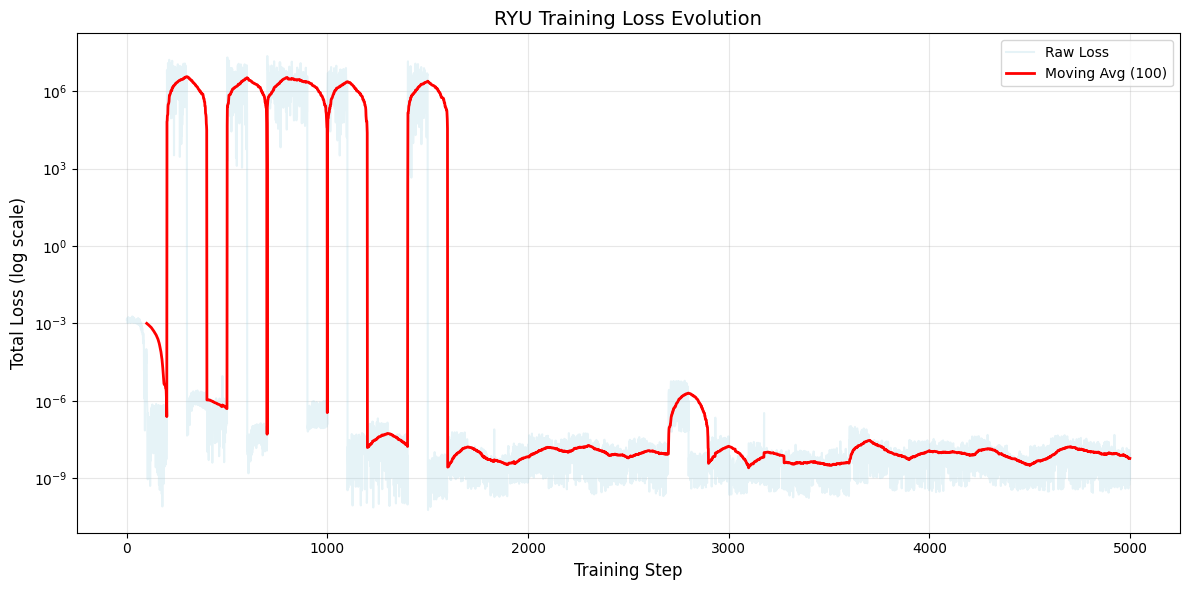

  📐 Dimensionless time range: [0, 1.0]
  📐 Fixed dimensionless potential: 0.800


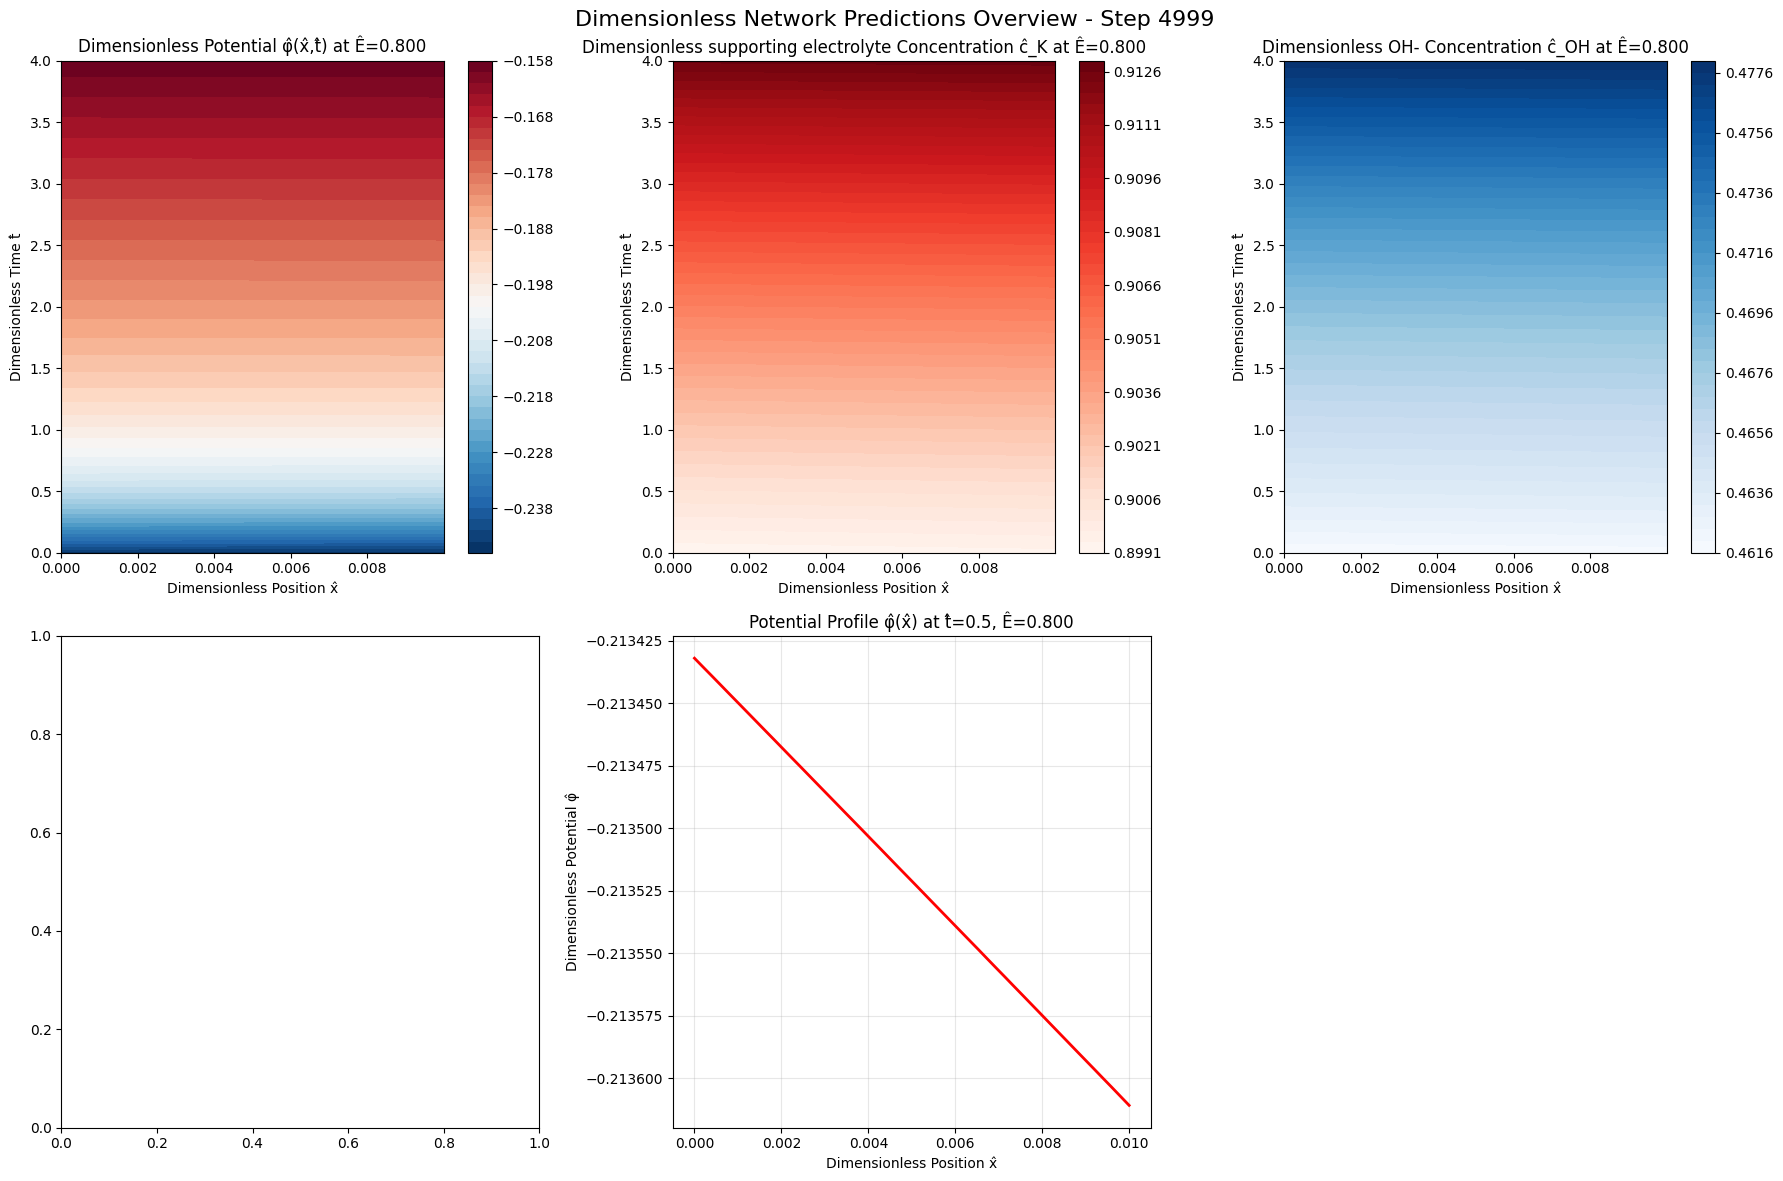

In [ ]:
# Plotting

plt.figure(figsize=(12, 6))
window = 100
# Raw loss
plt.plot(loss_list, alpha=0.3, color='lightblue', label='Raw Loss')

# Moving average for smoother trend
if len(loss_list) > window:
    moving_avg = np.convolve(loss_list, np.ones(window)/window, mode='valid')
    plt.plot(range(window-1, len(loss_list)), moving_avg, 
        color='red', linewidth=2, label=f'Moving Avg ({window})')

plt.yscale('log')
plt.xlabel('Training Step', fontsize=12)
plt.ylabel('Total Loss (log scale)', fontsize=12)
plt.title('RYU Training Loss Evolution', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

with torch.no_grad():
    # Define input ranges (all dimensionless)
    n_spatial = 50
    n_temporal = 50

    # Fix a representative dimensionless potential for visualization
    E_hat_fixed = torch.tensor([[0.8 / phic]], device=device)  # Normalized E

    # Dimensionless time range (0 to 1)
    t_hat_range = torch.linspace(0, 4.0, n_temporal, device=device)

    t_hat_final = torch.tensor([[1.0]], device=device)
    x_hat_range = torch.linspace(0, L_domain, n_spatial, device=device)

    print(f"  📐 Dimensionless time range: [0, 1.0]")
    print(f"  📐 Fixed dimensionless potential: {E_hat_fixed.item():.3f}")

    # Create 2D grid for contour plots
    T_hat_mesh, X_hat_mesh = torch.meshgrid(t_hat_range, x_hat_range, indexing='ij')
    E_hat_mesh = torch.full_like(T_hat_mesh, E_hat_fixed.item())

    # Stack inputs for 3D networks
    inputs_3d = torch.stack([
        X_hat_mesh.flatten(),
        T_hat_mesh.flatten(),
        E_hat_mesh.flatten()
    ], dim=1)

    # Get network predictions
    phi_hat_2d = u_net(inputs_3d).reshape(n_temporal, n_spatial)
    c_k_hat_2d = k_net(inputs_3d).reshape(n_temporal, n_spatial)
    c_oh_hat_2d = oh_net(inputs_3d).reshape(n_temporal, n_spatial)

    # Convert to numpy for plotting
    t_hat_np = t_hat_range.cpu().numpy()
    x_hat_np = x_hat_range.cpu().numpy()
    T_hat_np, X_hat_np = np.meshgrid(t_hat_np, x_hat_np, indexing='ij')

    phi_hat_np = phi_hat_2d.cpu().numpy()
    c_k_hat_np = c_k_hat_2d.cpu().numpy()
    c_oh_hat_np = c_oh_hat_2d.cpu().numpy()

    # Create plots - Changed to 2 rows, 2 columns to fit all 4 contour plots + 1 line plot
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. Dimensionless potential field
    im1 = axes[0, 0].contourf(X_hat_np, T_hat_np, phi_hat_np, levels=50, cmap='RdBu_r')
    axes[0, 0].set_xlabel('Dimensionless Position x̂')
    axes[0, 0].set_ylabel('Dimensionless Time t̂')
    axes[0, 0].set_title(f'Dimensionless Potential φ̂(x̂,t̂) at Ê={E_hat_fixed.item():.3f}')
    plt.colorbar(im1, ax=axes[0, 0])

    # 2. Dimensionless cation vacancies
    im2 = axes[0, 1].contourf(X_hat_np, T_hat_np, c_k_hat_np, levels=50, cmap='Reds')
    axes[0, 1].set_xlabel('Dimensionless Position x̂')
    axes[0, 1].set_ylabel('Dimensionless Time t̂')
    axes[0, 1].set_title(f'Dimensionless supporting electrolyte Concentration ĉ_K at Ê={E_hat_fixed.item():.3f}')
    plt.colorbar(im2, ax=axes[0, 1])

    # 3. Dimensionless anion vacancies
    im3 = axes[0, 2].contourf(X_hat_np, T_hat_np, c_oh_hat_np, levels=50, cmap='Blues')
    axes[0, 2].set_xlabel('Dimensionless Position x̂')
    axes[0, 2].set_ylabel('Dimensionless Time t̂')
    axes[0, 2].set_title(f'Dimensionless OH- Concentration ĉ_OH at Ê={E_hat_fixed.item():.3f}')
    plt.colorbar(im3, ax=axes[0, 2])

    # 5. Potential profile vs spatial position at fixed time - Fixed to use valid index and L_hat_final
    # Need to define L_hat_final since it's commented out above
    L_hat_final = L_domain  # Use L_domain as fallback
    
    x_hat_sweep = torch.linspace(0, L_hat_final, 50, device=device)
    t_hat_mid = torch.full((50, 1), 0.5, device=device)  # Middle time
    E_hat_mid = torch.full((50, 1), E_hat_fixed.item(), device=device)

    x_sweep_inputs = torch.cat([x_hat_sweep.unsqueeze(1), t_hat_mid, E_hat_mid], dim=1)
    phi_vs_x = u_net(x_sweep_inputs).cpu().numpy()

    axes[1, 1].plot(x_hat_sweep.cpu().numpy(), phi_vs_x, 'r-', linewidth=2)
    axes[1, 1].set_xlabel('Dimensionless Position x̂')
    axes[1, 1].set_ylabel('Dimensionless Potential φ̂')
    axes[1, 1].set_title(f'Potential Profile φ̂(x̂) at t̂=0.5, Ê={E_hat_fixed.item():.3f}')
    axes[1, 1].grid(True, alpha=0.3)

    # Hide the unused subplot [1, 2]
    axes[1, 2].set_visible(False)

    plt.suptitle(f'Dimensionless Network Predictions Overview - Step {step}', fontsize=16)
    plt.tight_layout()
    plt.show()

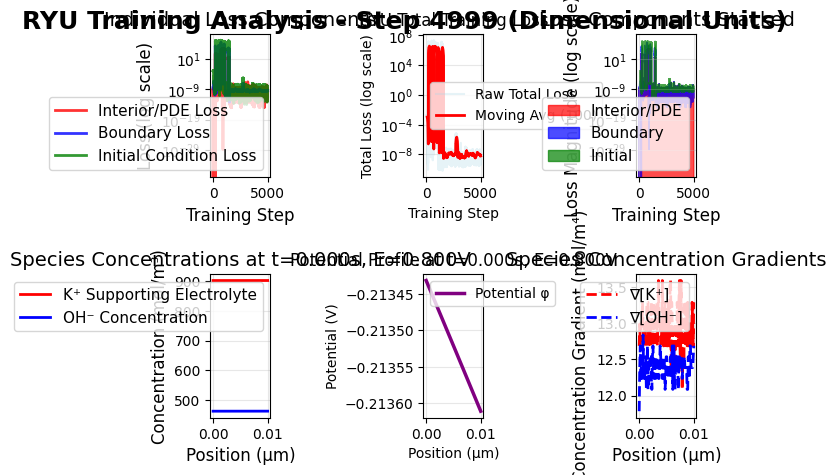


📊 DIMENSIONAL CONCENTRATION SUMMARY at t=0.000s:
  🔹 K⁺ range: [900.56, 900.69] mol/m³
  🔹 OH⁻ range: [463.63, 463.75] mol/m³
  🔹 Potential φ range: [-0.214, -0.213] V
  🔹 Domain: [0, 0.01] μm


In [ ]:
# --- LOSS PLOTS ---

# Plot 1: Individual Loss Components
plt.subplot(2, 3, 1)
plt.plot(interior_loss_list, 'red', linewidth=2, alpha=0.8, label='Interior/PDE Loss')
plt.plot(boundary_loss_list, 'blue', linewidth=2, alpha=0.8, label='Boundary Loss') 
#plt.plot(initial_loss_list, 'green', linewidth=2, alpha=0.8, label='Initial Condition Loss')

plt.yscale('log')
plt.xlabel('Training Step', fontsize=12)
plt.ylabel('Loss (log scale)', fontsize=12)
plt.title('Individual Loss Components', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Plot 2: Total Loss with Moving Average  
plt.subplot(2, 3, 2)
window = 100

# Raw total loss
plt.plot(loss_list, alpha=0.3, color='lightblue', label='Raw Total Loss')

# Moving average for smoother trend
if len(loss_list) > window:
    moving_avg = np.convolve(loss_list, np.ones(window)/window, mode='valid')
    plt.plot(range(window-1, len(loss_list)), moving_avg, 
            color='red', linewidth=2, label=f'Moving Avg ({window})')

plt.yscale('log')
plt.xlabel('Training Step')
plt.ylabel('Total Loss (log scale)')
plt.title('RYU Total Training Loss')
plt.grid(True, alpha=0.3)
plt.legend()

# Plot 3: Loss Components Stacked Area
plt.subplot(2, 3, 3)

# Create stacked area plot of loss components
if len(loss_list) > 0:
    steps = range(len(loss_list))
    plt.fill_between(steps, 0, interior_loss_list, alpha=0.7, color='red', label='Interior/PDE')
    plt.fill_between(steps, interior_loss_list, 
                    [interior_loss_list[i] + boundary_loss_list[i] for i in range(len(steps))], 
                    alpha=0.7, color='blue', label='Boundary')
    plt.fill_between(steps, 
                    [interior_loss_list[i] + boundary_loss_list[i] for i in range(len(steps))],
                    [interior_loss_list[i] + boundary_loss_list[i] + initial_loss_list[i] for i in range(len(steps))], 
                    alpha=0.7, color='green', label='Initial')

plt.yscale('log')
plt.xlabel('Training Step', fontsize=12)
plt.ylabel('Loss Magnitude (log scale)', fontsize=12)
plt.title('Loss Components Stacked', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# --- CONCENTRATION PROFILES (REDIMENSIONALIZED) ---
with torch.no_grad():
    # Define spatial range for concentration profiles
    n_spatial = 100
    E_hat_fixed = torch.tensor([[0.8 / phic]], device=device)
    x_hat_range = torch.linspace(0, L_domain, n_spatial, device=device)
    
    # Fixed conditions for concentration profiles
    t_hat_mid = torch.tensor([[0.5]], device=device)  # Middle time point
    
    # Prepare inputs for all networks
    t_hat_spatial = torch.full((n_spatial, 1), t_hat_mid.item(), device=device)
    E_hat_spatial = torch.full((n_spatial, 1), E_hat_fixed.item(), device=device)
    x_hat_spatial = x_hat_range.unsqueeze(1)
    
    spatial_inputs = torch.cat([x_hat_spatial, t_hat_spatial, E_hat_spatial], dim=1)
    
    # Get predictions from all networks (dimensionless)
    phi_hat_profile = u_net(spatial_inputs).cpu().numpy().flatten()
    c_k_hat_profile = k_net(spatial_inputs).cpu().numpy().flatten()
    c_oh_hat_profile = oh_net(spatial_inputs).cpu().numpy().flatten()
    
    # Convert to dimensional values
    x_dimensional = x_hat_range.cpu().numpy() * lc * 1e6  # Convert to μm
    t_dimensional = t_hat_mid.item() * tc  # Convert to seconds
    phi_dimensional = phi_hat_profile * phic  # Convert to Volts
    c_k_dimensional = c_k_hat_profile * cc  # Convert to mol/m³
    c_oh_dimensional = c_oh_hat_profile * cc  # Convert to mol/m³

# Plot 4: All Concentrations (Dimensional)
plt.subplot(2, 3, 4)
plt.plot(x_dimensional, c_k_dimensional, 'r-', linewidth=2, label='K⁺ Supporting Electrolyte')
plt.plot(x_dimensional, c_oh_dimensional, 'b-', linewidth=2, label='OH⁻ Concentration')
plt.xlabel('Position (μm)', fontsize=12)
plt.ylabel('Concentration (mol/m³)', fontsize=12)
plt.title(f'Species Concentrations at t={t_dimensional:.3f}s, E={E_hat_fixed.item()*phic:.3f}V', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Plot 5: Potential Profile (Dimensional)
plt.subplot(2, 3, 5)
plt.plot(x_dimensional, phi_dimensional, 'purple', linewidth=2.5, label='Potential φ')
plt.xlabel('Position (μm)')
plt.ylabel('Potential (V)')
plt.title(f'Potential Profile at t={t_dimensional:.3f}s, E={E_hat_fixed.item()*phic:.3f}V')
plt.grid(True, alpha=0.3)
plt.legend()

# Plot 6: Concentration Gradients
plt.subplot(2, 3, 6)
# Calculate gradients using finite differences
dx = x_dimensional[1] - x_dimensional[0]
grad_k = np.gradient(c_k_dimensional, dx)
grad_oh = np.gradient(c_oh_dimensional, dx)

plt.plot(x_dimensional, grad_k, 'r--', linewidth=2, label='∇[K⁺]')
plt.plot(x_dimensional, grad_oh, 'b--', linewidth=2, label='∇[OH⁻]')
plt.xlabel('Position (μm)', fontsize=12)
plt.ylabel('Concentration Gradient (mol/m⁴)', fontsize=12)
plt.title('Species Concentration Gradients', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.suptitle(f'RYU Training Analysis - Step {step} (Dimensional Units)', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.93)  # Make room for the main title
plt.show()

# Print dimensional summary
print(f"\n📊 DIMENSIONAL CONCENTRATION SUMMARY at t={t_dimensional:.3f}s:")
print(f"  🔹 K⁺ range: [{c_k_dimensional.min():.2f}, {c_k_dimensional.max():.2f}] mol/m³")
print(f"  🔹 OH⁻ range: [{c_oh_dimensional.min():.2f}, {c_oh_dimensional.max():.2f}] mol/m³")
print(f"  🔹 Potential φ range: [{phi_dimensional.min():.3f}, {phi_dimensional.max():.3f}] V")
print(f"  🔹 Domain: [0, {x_dimensional.max():.2f}] μm")